In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import f1_score, balanced_accuracy_score
import pickle
from PIL import Image
from tqdm.notebook import tqdm

In [ ]:
# open an image
img = Image.open('database/9491931/d125s0001.jpg')
img

In [3]:
# Load the paths to the images in a directory

def load_images_from_folder(folder,only_path = False, label = ""):
    # When only path is false it only returns paths
    # But if not it returns images too
    if only_path == False:
        images = []
        file_name=[]
        for filename in os.listdir(folder):
            img = plt.imread(os.path.join(folder,filename))

            if img is not None:
                end=filename.find(".")
                file_name.append(filename[0:end])
                images.append(img)

        return images, file_name
    else:
        path = []
        for filename in os.listdir(folder):
            img_path = os.path.join(folder,filename)
            if img_path is not None:
                path.append([label,img_path])
        return path

In [4]:
# Load the paths on the images
images = []
path = "database/"
for f in os.listdir(path):
    if "jpg" in os.listdir(path+f)[0]:
        images += load_images_from_folder(path+f,True,label = f)

    else:
        for d in os.listdir(path+f):
            images += load_images_from_folder(path+f+"/"+d,True,label = f)


# Create a dataframe with the paths and the label for each insect

df1 = pd.DataFrame(images, columns = ["insect_gbif", "path_img"])

file_name=[]
for i in range(len(df1["path_img"])):
    temp=df1.path_img[i].split('/')[-1].split('\\')[-1].split('.')[0]
    file_name.append(temp)
file_name

df1 = df1.drop(columns=['path_img'])
df1['file_name'] = file_name
display(df1)

,insect_gbif,file_name
0,9491931,d125s0001
1,9491931,d125s0002
2,9491931,d125s0003
3,9491931,d125s0004
4,9491931,d125s0005
...,...,...
911,9581584,d135s0406
912,9581584,d135s0407
913,9581584,d135s0408
914,9581584,d135s0409


In [5]:
labels = df1["insect_gbif"].unique()

labels_dict = dict(zip(range(len(labels)),labels))
labels_dict

{0: '9491931', 1: '9533851', 2: '9581584'}

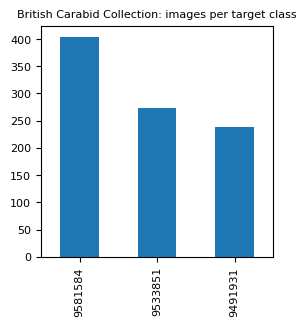

In [6]:
# plot distribution of images per class
bar = df1["insect_gbif"].value_counts().plot.bar(figsize = (3,3))
plt.title("British Carabid Collection: images per target class", fontsize = 8)
bar.tick_params(labelsize=8)
plt.show()

In [7]:
df1["insect_gbif"].value_counts()

9581584    404
9533851    273
9491931    239
Name: insect_gbif, dtype: int64

In [9]:
!pip install split-folders -qqq
# Split with a ratio.
import splitfolders
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("database/", output="output", seed=1337, ratio=(.75, .15, .1), group_prefix=None) # default values

In [11]:
datapath = "output/"
training_path = os.path.join(datapath, 'train')
validation_path = os.path.join(datapath, 'val')
test_path = os.path.join(datapath, 'test')

# Count files in subdirectories
def file_count(path):
   return sum(len(files) for _, _, files in os.walk(path))

print("training set:", len(os.listdir(training_path))," classes, ", file_count(training_path), " files in subfolders")
print("validation set:", len(os.listdir(validation_path)), " classes, ", file_count(validation_path), " files in subfolders")
print("test set:", len(os.listdir(test_path)), " classes, ", file_count(test_path), " files in subfolders")

output/test
training set: 3  classes,  686  files in subfolders
validation set: 3  classes,  135  files in subfolders
test set: 3  classes,  95  files in subfolders


In [12]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(270, expand=True),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = datapath
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
labels = image_datasets['train'].targets
class_counts = np.unique(labels, return_counts=True)[1]
num_samples = sum(class_counts)
class_weights = [num_samples / class_counts[i] for i in range(len(class_counts))]
weights = [class_weights[labels[i]] for i in range(int(num_samples))]
sampler_train = torch.utils.data.sampler.WeightedRandomSampler(
    torch.DoubleTensor(weights), int(num_samples)
)
dataloaders = dict()
dataloaders['train'] = torch.utils.data.DataLoader(image_datasets['train'],
                                                   batch_size=4,
                                                  sampler=sampler_train)
dataloaders['val'] = torch.utils.data.DataLoader(image_datasets['val'],
                                                 batch_size=4, shuffle=False)
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                            # sampler=sampler_train)
              # for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print class names & set sizes
print(class_names)
print(dataset_sizes)
print(type(dataloaders['train']))

['9491931', '9533851', '9581584']
{'train': 686, 'val': 135}
<class 'torch.utils.data.dataloader.DataLoader'>


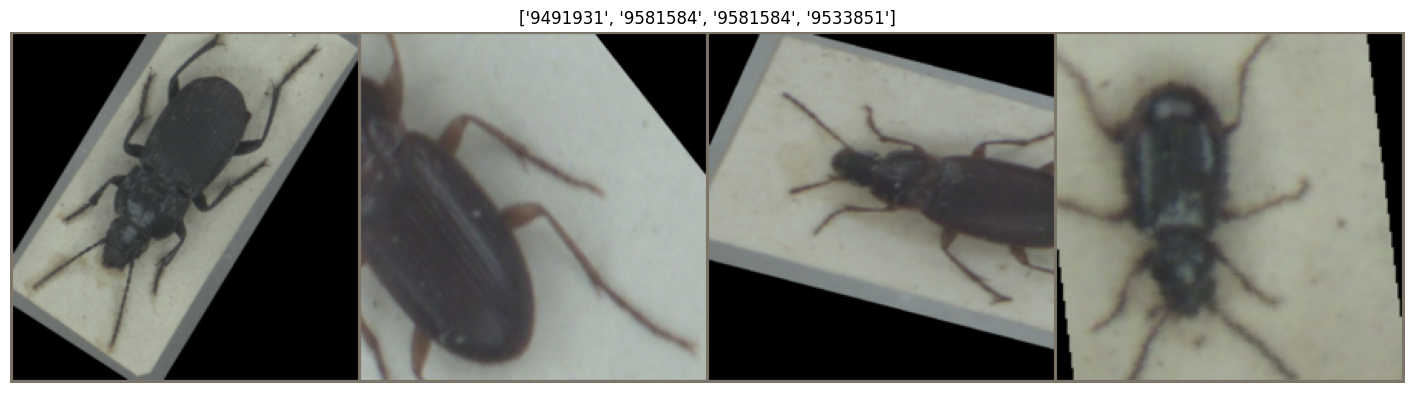

In [16]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=4, padding=2)
fig = plt.figure(figsize=(18, 8), facecolor='w')

imshow(out, title=[class_names[x] for x in classes])

In [22]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            # running_f1_score = 0.0
            arr_pred = torch.from_numpy(np.array([])).to(device)
            arr_labl = torch.from_numpy(np.array([])).to(device)

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase],desc="Batches - {}".format(phase)):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                # running_f1_score += f1_score(labels.cpu().data, preds.cpu(), average="weighted")
                arr_pred = torch.cat((arr_pred, preds))
                arr_labl = torch.cat((arr_labl, labels.data))
            if phase == 'train':
                scheduler.step()

            epoch_f1 = f1_score(arr_labl.flatten().cpu(), arr_pred.flatten().cpu(), average="weighted")
            epoch_f1_micro = f1_score(arr_labl.flatten().cpu(), arr_pred.flatten().cpu(), average="micro")
            epoch_acc_wgt = balanced_accuracy_score(arr_labl.flatten().cpu(), arr_pred.flatten().cpu())

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} | Acc: {:.4f} | F1(wgt): {:.4f} | F1(micro): {:.4f}'.format(
                phase, epoch_loss, epoch_acc, epoch_f1, epoch_f1_micro))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # print(f"best_acc:{best_acc}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [23]:
def visualize_model(model, device, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, GT: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [24]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

C:\Users\efein\PycharmProjects\insect-classifier\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\efein\PycharmProjects\insect-classifier\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 1/10
----------


Batches - train:   0%|          | 0/172 [00:00<?, ?it/s]

train Loss: 0.5225 | Acc: 0.7770 | F1(wgt): 0.7772 | F1(micro): 0.7770


Batches - val:   0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.0495 | Acc: 0.9926 | F1(wgt): 0.9926 | F1(micro): 0.9926

Epoch 2/10
----------


Batches - train:   0%|          | 0/172 [00:00<?, ?it/s]

train Loss: 0.4239 | Acc: 0.8630 | F1(wgt): 0.8631 | F1(micro): 0.8630


Batches - val:   0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.0087 | Acc: 1.0000 | F1(wgt): 1.0000 | F1(micro): 1.0000

Epoch 3/10
----------


Batches - train:   0%|          | 0/172 [00:00<?, ?it/s]

train Loss: 0.3990 | Acc: 0.8586 | F1(wgt): 0.8581 | F1(micro): 0.8586


Batches - val:   0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.0204 | Acc: 1.0000 | F1(wgt): 1.0000 | F1(micro): 1.0000

Epoch 4/10
----------


Batches - train:   0%|          | 0/172 [00:00<?, ?it/s]

train Loss: 0.3162 | Acc: 0.8863 | F1(wgt): 0.8861 | F1(micro): 0.8863


Batches - val:   0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.1411 | Acc: 0.9556 | F1(wgt): 0.9559 | F1(micro): 0.9556

Epoch 5/10
----------


Batches - train:   0%|          | 0/172 [00:00<?, ?it/s]

train Loss: 0.3545 | Acc: 0.8980 | F1(wgt): 0.8979 | F1(micro): 0.8980


Batches - val:   0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.0107 | Acc: 1.0000 | F1(wgt): 1.0000 | F1(micro): 1.0000

Epoch 6/10
----------


Batches - train:   0%|          | 0/172 [00:00<?, ?it/s]

train Loss: 0.2956 | Acc: 0.9082 | F1(wgt): 0.9080 | F1(micro): 0.9082


Batches - val:   0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.0074 | Acc: 1.0000 | F1(wgt): 1.0000 | F1(micro): 1.0000

Epoch 7/10
----------


Batches - train:   0%|          | 0/172 [00:00<?, ?it/s]

train Loss: 0.2969 | Acc: 0.9009 | F1(wgt): 0.9007 | F1(micro): 0.9009


Batches - val:   0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.0061 | Acc: 1.0000 | F1(wgt): 1.0000 | F1(micro): 1.0000

Epoch 8/10
----------


Batches - train:   0%|          | 0/172 [00:00<?, ?it/s]

train Loss: 0.1311 | Acc: 0.9650 | F1(wgt): 0.9650 | F1(micro): 0.9650


Batches - val:   0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.0058 | Acc: 1.0000 | F1(wgt): 1.0000 | F1(micro): 1.0000

Epoch 9/10
----------


Batches - train:   0%|          | 0/172 [00:00<?, ?it/s]

train Loss: 0.1996 | Acc: 0.9402 | F1(wgt): 0.9402 | F1(micro): 0.9402


Batches - val:   0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.0056 | Acc: 1.0000 | F1(wgt): 1.0000 | F1(micro): 1.0000

Epoch 10/10
----------


Batches - train:   0%|          | 0/172 [00:00<?, ?it/s]

train Loss: 0.1709 | Acc: 0.9461 | F1(wgt): 0.9462 | F1(micro): 0.9461


Batches - val:   0%|          | 0/34 [00:00<?, ?it/s]

val Loss: 0.0052 | Acc: 1.0000 | F1(wgt): 1.0000 | F1(micro): 1.0000

Training complete in 12m 34s
Best val Acc: 1.000000


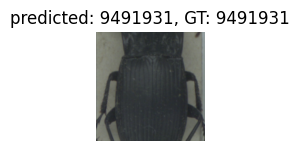

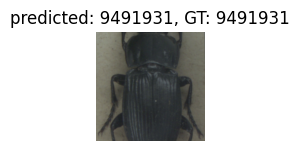

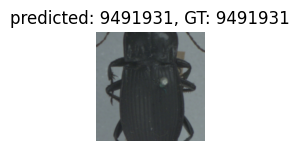

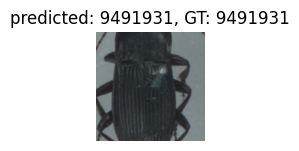

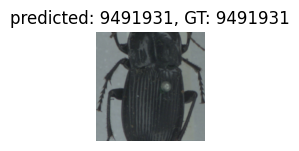

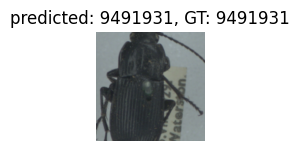

In [26]:
visualize_model(model_ft, device)

In [42]:
torch.save(model_ft.state_dict(), 'models/model.pth')
pickle.dump(class_names, open('models/model.pkl', "wb"), pickle.HIGHEST_PROTOCOL)

efe


In [45]:
path_class_names = 'models/model.pkl'
path_model = 'models/model.pth'
class_names = pickle.load(open(path_class_names, "rb"))
print(class_names)

['9491931', '9533851', '9581584']


In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [47]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

C:\Users\efein\PycharmProjects\insect-classifier\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\efein\PycharmProjects\insect-classifier\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [49]:
model_ft.load_state_dict(copy.deepcopy(torch.load(path_model,device)))

<All keys matched successfully>

In [50]:
# normalization for testing
data_transforms_test = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [51]:
import datetime

# run predictions on test set
for subdir, dirs, files in os.walk(test_path):
    for file in files:
      img_path = os.path.join(subdir,file)
      img = Image.open(img_path)
      img_t = data_transforms_test(img)
      batch_t = torch.unsqueeze(img_t, 0)
      model_ft.eval()
      # We don't need gradients for test, so wrap in ~
      # no_grad to save memory
      with torch.no_grad():
          batch_t = batch_t.to(device)
          # forward propagation
          output = model_ft( batch_t)
          # get prediction
          probs = torch.nn.functional.softmax(output, dim=1)
          conf, output = torch.max(probs, 1)
          # output = torch.argmax(output, 1)

      print(datetime.datetime.now(), os.path.relpath(img_path, test_path))
      print("Class: {}, confidence score: {:.2f}".format(class_names[output.cpu()], conf[0]))

2023-02-17 18:14:19.255716 9491931\d125s0028.jpg
Class: 9491931, confidence score: 1.00
2023-02-17 18:14:19.302597 9491931\d125s0043.jpg
Class: 9491931, confidence score: 0.98
2023-02-17 18:14:19.365067 9491931\d125s0053.jpg
Class: 9491931, confidence score: 1.00
2023-02-17 18:14:19.424031 9491931\d125s0079.jpg
Class: 9491931, confidence score: 1.00
2023-02-17 18:14:19.481327 9491931\d125s0086.jpg
Class: 9491931, confidence score: 1.00
2023-02-17 18:14:19.528204 9491931\d125s0094.jpg
Class: 9491931, confidence score: 1.00
2023-02-17 18:14:19.576508 9491931\d125s0095.jpg
Class: 9491931, confidence score: 1.00
2023-02-17 18:14:19.623372 9491931\d125s0100.jpg
Class: 9491931, confidence score: 1.00
2023-02-17 18:14:19.654614 9491931\d125s0102.jpg
Class: 9491931, confidence score: 1.00
2023-02-17 18:14:19.712600 9491931\d125s0110.jpg
Class: 9491931, confidence score: 1.00
2023-02-17 18:14:19.785429 9491931\d125s0138.jpg
Class: 9491931, confidence score: 1.00
2023-02-17 18:14:19.838288 94919